# Comparing ANHA4 Ba with Obs

This is the notebook I used to compare modeled Ba with field observations. - 2016/01/26

** Model output: **

* Spin-up 6 years (2002-2004)*2
* ANHA4-EXH001

** Observations: **

* GIPY11 Aug 2007
* BGEP Aug 2003-2005
* HLY Aug 2003
* CBL Sep 2002

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.setdefaultencoding('utf8')
sys.path.insert(0, '../../_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, cm
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [5]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = np.linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

In [6]:
np.set_printoptions(threshold='nan')

# Get the data ready

In [7]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360

In [8]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

In [9]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/HLY_Ba.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); BaH = np.squeeze(MAT['Ba'][:])

In [10]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/CBL_Ba.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); BaC = np.squeeze(MAT['Ba'][:])

In [11]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARK09_Ba.mat')
xA9 = np.squeeze(MAT['lon'][:]); yA9 = np.squeeze(MAT['lat'][:]); zA9 = np.squeeze(MAT['dep'][:]); BaA9 = np.squeeze(MAT['Ba'][:])

In [12]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARK14_Ba.mat')
xA14 = np.squeeze(MAT['lon'][:]); yA14 = np.squeeze(MAT['lat'][:]); zA14 = np.squeeze(MAT['dep'][:]); BaA14 = np.squeeze(MAT['Ba'][:])

In [15]:
#MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/NPEO_Ba.mat')
#xNPEO = np.squeeze(MAT['lon'][:]); yNPEO = np.squeeze(MAT['lat'][:]); zNPEO = np.squeeze(MAT['dep'][:]); BaNPEO = np.squeeze(MAT['Ba'][:])

In [16]:
MAT = scipy.io.loadmat('../../_data/MAT files/Processed samples/ARC_Ba.mat')
xARC = np.squeeze(MAT['lon'][:]); yARC = np.squeeze(MAT['lat'][:]); zARC = np.squeeze(MAT['dep'][:]); BaARC = np.squeeze(MAT['Ba'][:])

In [102]:
BGEP_lons = np.hstack((x03, x04, x05))
BGEP_lats = np.hstack((y03, y04, y05))
BGEP_deps = np.hstack((z03, z04, z05))
BGEP_Ba   = np.hstack((Ba03, Ba04, Ba05))

In [114]:
x_all = np.hstack((GIPY_lons, x05)) # xA14, xNPEO, xARC
y_all = np.hstack((GIPY_lats, y05))
z_all = np.hstack((GIPY_deps, z05))
Ba_all = np.hstack((GIPY_Ba, Ba05))

In [115]:
x_compare = x_all[z_all<6.5]
y_compare = y_all[z_all<6.5]
Ba_compare = Ba_all[z_all<6.5]

In [116]:
ANHA4_MAT=scipy.io.loadmat('../../_data/Exchange/coord_ANHA4.mat')
deptht = ANHA4_MAT['nav_lev'][:]

# Model output

In [117]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'

In [118]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][66, 0, :, :]) #67
Ba[Ba==0]=np.nan
#Ba = np.nanmean(Ba, 0)
#Ba = Ba-4
#Ba2 = np.squeeze(ptrc_obj.variables['Ba'][time_ind, :, :, :])
#Ba2[np.isnan(Ba)]=np.nan
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]

#deptht = ptrc_obj.variables['deptht'][:]

In [119]:
ind1, ind2 = Nts.nearest_search(nav_lon, nav_lat, x_compare, y_compare)

In [120]:
Ba_compare = Ba_compare[ind1>0]
x_all = x_compare[ind1>0]
y_all = y_compare[ind1>0]
ind1=ind1[ind1>0]
ind2=ind2[ind2>0]


In [122]:
Ba_model = Ba[ind1, ind2]

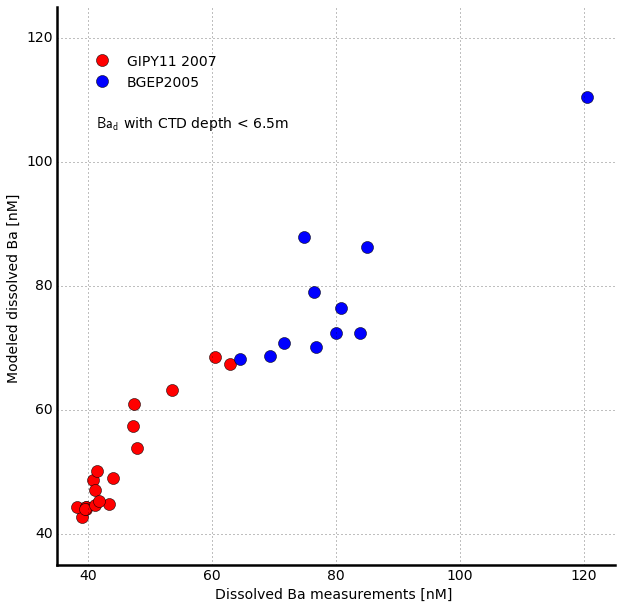

In [164]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

#ax.grid(linestyle=':')
ax.grid()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax.spines.itervalues()]
ax.set_xlim([35, 125])
ax.set_ylim([35, 125])
#ax.set_yticks(np.arange(-2.2, -1.8, 0.1)); ax1.set_ylim([-2.3, -1.7])
ax.set_ylabel('Modeled dissolved Ba [nM] ', fontsize=14)
ax.set_xlabel('Dissolved Ba measurements [nM] ', fontsize=14)
#ax.set_xlim([date_list[6], date_list[-6]])
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")


ax.plot(Ba_compare[:20], Ba_model[:20], 'ro', label='GIPY11 2007', ms=12)
ax.plot(Ba_compare[20:], Ba_model[20:], 'bo', label='BGEP2005', ms=12)
ax.set_title('$\mathsf{Ba_d}$ with CTD depth < 6.5m', loc='left', x=0.07, y=0.775, fontsize=14)
LG=ax.legend(bbox_to_anchor=(0.02, 0.95), loc=2, borderaxespad=1, numpoints=1, prop={'size':14}); LG.draw_frame(False)

fig.savefig('../../Ba_comp_1.png', dpi=300, orientation='portrait', papertype='a4', format='png',
                bbox_inches='tight', pad_inches=0.1)

In [101]:
y_all

array([  33.9816 ,   34.0108 ,   34.0257 ,   33.9968 ,   36.0943 ,
         60.9212 ,   61.7437 ,   61.7437 ,   60.7951 ,   61.9944 ,
         68.9631 ,   86.271  ,   89.9247 ,   91.1776 ,  104.8    ,
        139.604  ,  153.71001,  124.372  ])

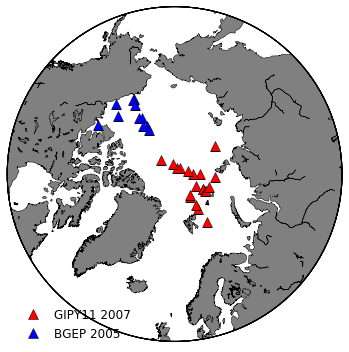

In [165]:
fig=plt.figure(figsize=(6, 6));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=0, round=True, ax=ax)
#proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x_GIPY, y_GIPY = proj(x_all[:20], y_all[:20])
x_BGEP, y_BGEP = proj(x_all[20:], y_all[20:])
proj.plot(x_GIPY, y_GIPY, 'r^', label = 'GIPY11 2007', ms=10)
proj.plot(x_BGEP, y_BGEP, 'b^', label = 'BGEP 2005', ms=10)

LG=ax.legend(bbox_to_anchor=(-0.01, 0.15), loc=2, borderaxespad=1, numpoints=1); LG.draw_frame(False)

fig.savefig('../../Ba_comp_2.png', dpi=150, orientation='portrait', papertype='a4', format='png',
                bbox_inches='tight', pad_inches=0.1)